# Coin Metrics Options Data Aggregation

This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client and Market Data Feed.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

## Resources
To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Product Documentation](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

## Notebook Setup

In [1]:
import os
from os import environ
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import json
import logging
from datetime import timezone as timezone_info
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from plotly import graph_objects as go

In [2]:
sns.set_theme()
sns.set(rc={'figure.figsize':(14,8)})
sns.set_style("whitegrid",{'axes.grid' : True,'grid.linestyle': '--', 'grid.color': 'gray','axes.edgecolor': 'white'})

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")

client = CoinMetricsClient(api_key)

2024-09-11 13:31:07 INFO     Using API key found in environment


### Set start and end time

In [5]:
end = datetime.utcnow()
start = '2024-09-01'
end = '2024-09-08'
asset = 'eth'

## OPTIONS CATALOG

To simplify some of the complexity around options contract size, we will investigate only options markets on Deribit, the largest options exchange by volume.

In [6]:
asset_options = client.reference_data_markets(
    type='option',
    exchange='deribit',
    base='eth',
    quote='usd',
    page_size=10000
).to_list()

In [7]:
print('Total number of supported options markets: ' + str(len(asset_options)))

Total number of supported options markets: 74751


### Filter out expired/inactive contracts

In [8]:
df_asset_options = pd.DataFrame(asset_options)

In [9]:
df_asset_options.head()

,market,exchange,type,base,quote,pair,symbol,size_asset,strike,option_contract_type,...,listing,expiration,settlement_price,status,order_amount_min,order_price_increment,order_taker_fee,order_maker_fee,base_native,quote_native
0,deribit-ETH-10APR20-100-P-option,deribit,option,eth,usd,eth-usd,ETH-10APR20-100-P,eth,100,put,...,2020-03-26T08:00:02.000000000Z,2020-04-10T08:00:00.000000000Z,158.1,offline,1,0.0005,0.0004,0.0004,NaN,NaN
1,deribit-ETH-10APR20-110-P-option,deribit,option,eth,usd,eth-usd,ETH-10APR20-110-P,eth,110,put,...,2020-03-26T08:00:02.000000000Z,2020-04-10T08:00:00.000000000Z,158.1,offline,1,0.0005,0.0004,0.0004,NaN,NaN
2,deribit-ETH-10APR20-120-C-option,deribit,option,eth,usd,eth-usd,ETH-10APR20-120-C,eth,120,call,...,2020-03-26T08:00:02.000000000Z,2020-04-10T08:00:00.000000000Z,158.1,offline,1,0.0005,0.0004,0.0004,NaN,NaN
3,deribit-ETH-10APR20-120-P-option,deribit,option,eth,usd,eth-usd,ETH-10APR20-120-P,eth,120,put,...,2020-03-26T08:00:02.000000000Z,2020-04-10T08:00:00.000000000Z,158.1,offline,1,0.0005,0.0004,0.0004,NaN,NaN
4,deribit-ETH-10APR20-130-C-option,deribit,option,eth,usd,eth-usd,ETH-10APR20-130-C,eth,130,call,...,2020-03-26T08:00:02.000000000Z,2020-04-10T08:00:00.000000000Z,158.1,offline,1,0.0005,0.0004,0.0004,NaN,NaN


In [10]:
df_asset_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74751 entries, 0 to 74750
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   market                 74751 non-null  object
 1   exchange               74751 non-null  object
 2   type                   74751 non-null  object
 3   base                   74751 non-null  object
 4   quote                  74751 non-null  object
 5   pair                   74751 non-null  object
 6   symbol                 74751 non-null  object
 7   size_asset             74751 non-null  object
 8   strike                 74751 non-null  object
 9   option_contract_type   74751 non-null  object
 10  is_european            74751 non-null  bool  
 11  contract_size          74751 non-null  object
 12  listing                74751 non-null  object
 13  expiration             74751 non-null  object
 14  settlement_price       74065 non-null  object
 15  status             

In [11]:
df_asset_options['listing'] = pd.to_datetime(df_asset_options['listing'])
df_asset_options['expiration'] = pd.to_datetime(df_asset_options['expiration'])

df_asset_options = df_asset_options.loc[((df_asset_options.listing > start) & (df_asset_options.listing < end))]
df_asset_options

,market,exchange,type,base,quote,pair,symbol,size_asset,strike,option_contract_type,...,listing,expiration,settlement_price,status,order_amount_min,order_price_increment,order_taker_fee,order_maker_fee,base_native,quote_native
2384,deribit-ETH-10SEP24-1950-C-option,deribit,option,eth,usd,eth-usd,ETH-10SEP24-1950-C,eth,1950,call,...,2024-09-07 08:00:09+00:00,2024-09-10 08:00:00+00:00,2360.48,offline,1,0.0001,0.0003,0.0003,ETH,USD
2385,deribit-ETH-10SEP24-1950-P-option,deribit,option,eth,usd,eth-usd,ETH-10SEP24-1950-P,eth,1950,put,...,2024-09-07 08:00:09+00:00,2024-09-10 08:00:00+00:00,2360.48,offline,1,0.0001,0.0003,0.0003,ETH,USD
2386,deribit-ETH-10SEP24-2000-C-option,deribit,option,eth,usd,eth-usd,ETH-10SEP24-2000-C,eth,2000,call,...,2024-09-07 08:00:09+00:00,2024-09-10 08:00:00+00:00,2360.48,offline,1,0.0001,0.0003,0.0003,ETH,USD
2387,deribit-ETH-10SEP24-2000-P-option,deribit,option,eth,usd,eth-usd,ETH-10SEP24-2000-P,eth,2000,put,...,2024-09-07 08:00:09+00:00,2024-09-10 08:00:00+00:00,2360.48,offline,1,0.0001,0.0003,0.0003,ETH,USD
2388,deribit-ETH-10SEP24-2050-C-option,deribit,option,eth,usd,eth-usd,ETH-10SEP24-2050-C,eth,2050,call,...,2024-09-07 08:00:09+00:00,2024-09-10 08:00:00+00:00,2360.48,offline,1,0.0001,0.0003,0.0003,ETH,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74746,deribit-ETH-9SEP24-2800-P-option,deribit,option,eth,usd,eth-usd,ETH-9SEP24-2800-P,eth,2800,put,...,2024-09-06 08:00:10+00:00,2024-09-09 08:00:00+00:00,2311.75,offline,1,0.0001,0.0003,0.0003,ETH,USD
74747,deribit-ETH-9SEP24-2850-C-option,deribit,option,eth,usd,eth-usd,ETH-9SEP24-2850-C,eth,2850,call,...,2024-09-06 08:00:10+00:00,2024-09-09 08:00:00+00:00,2311.75,offline,1,0.0001,0.0003,0.0003,ETH,USD
74748,deribit-ETH-9SEP24-2850-P-option,deribit,option,eth,usd,eth-usd,ETH-9SEP24-2850-P,eth,2850,put,...,2024-09-06 08:00:10+00:00,2024-09-09 08:00:00+00:00,2311.75,offline,1,0.0001,0.0003,0.0003,ETH,USD
74749,deribit-ETH-9SEP24-2900-C-option,deribit,option,eth,usd,eth-usd,ETH-9SEP24-2900-C,eth,2900,call,...,2024-09-06 10:37:00+00:00,2024-09-09 08:00:00+00:00,2311.75,offline,1,0.0001,0.0003,0.0003,ETH,USD


# TRADE VOLUME

On Deribit, each option contract provides notional exposure to 1 unit of the underlying asset (i.e. 1 BTC or 1 ETH). To calculate options volume, we must multiply the 'amount' field (representing the number of contracts traded) by the USD price of the underlying asset. 

In [12]:
list_options_markets = list(df_asset_options.market.unique())

In [13]:
full_vol = pd.DataFrame()
batch_size = 420

for i in range(0, len(list_options_markets),batch_size):
    mkt_batch = list_options_markets[i:i+batch_size]
    print(str('Retrieving batch of trades for markets ' + str(i) + ' - ' + str(i+batch_size) + '...'))

    vol_batch = client.get_market_trades(
        markets=mkt_batch,
        start_time = start,
        end_time= end,
        page_size=10000
    ).to_dataframe()
    print('Retrieved batch of ' + str(len(vol_batch)) + ' trades')
    
    full_vol = pd.concat((full_vol, vol_batch), axis = 0, ignore_index=False)
    print('Total of ' + str(len(full_vol)) + ' trades\n')

full_vol = full_vol.reset_index(drop=True)

Retrieving batch of trades for markets 0 - 420...
Retrieved batch of 12012 trades
Total of 12012 trades



In [14]:
full_vol = full_vol[['market','time','amount']]
full_vol = full_vol[~(full_vol['time'] > end)]
full_vol.sort_values('time')

,market,time,amount
1071,deribit-ETH-3SEP24-2375-P-option,2024-09-01 06:55:13.947000+00:00,1
1072,deribit-ETH-3SEP24-2375-P-option,2024-09-01 08:04:42.145000+00:00,1
1073,deribit-ETH-3SEP24-2375-P-option,2024-09-01 08:07:41.254000+00:00,3
2429,deribit-ETH-4SEP24-2550-C-option,2024-09-01 08:33:21.911000+00:00,1
2805,deribit-ETH-4SEP24-2700-C-option,2024-09-01 08:47:26.803000+00:00,14
...,...,...,...
11208,deribit-ETH-9SEP24-2300-C-option,2024-09-07 23:54:16.170000+00:00,9
9225,deribit-ETH-8SEP24-2325-C-option,2024-09-07 23:54:52.991000+00:00,2
8166,deribit-ETH-8SEP24-2050-P-option,2024-09-07 23:57:33.509000+00:00,2
9650,deribit-ETH-8SEP24-2400-C-option,2024-09-07 23:58:04.697000+00:00,1


### Retrieve 1-minute Reference Rate

In [15]:
df_refrate = client.get_asset_metrics(
    assets=asset,
    frequency='1m',
    metrics='ReferenceRateUSD',
    start_time=start,
    end_time=end
).to_dataframe()

In [16]:
df_refrate = df_refrate.set_index('time').sort_index().drop(columns=['asset'])
df_refrate

,ReferenceRateUSD
time,
2024-09-01 00:00:00+00:00,2512.79
2024-09-01 00:01:00+00:00,2512.41
2024-09-01 00:02:00+00:00,2510.65
2024-09-01 00:03:00+00:00,2513.37
2024-09-01 00:04:00+00:00,2511.32
...,...
2024-09-08 23:55:00+00:00,2298.15
2024-09-08 23:56:00+00:00,2297.49
2024-09-08 23:57:00+00:00,2294.79


In [17]:
full_vol['time'] = full_vol['time'].round('T')

# Merge trades data with 1s reference rate
full_vol = full_vol.merge(df_refrate.reset_index(),how='left', on='time')

### Calculate USD value of trades

In [18]:
full_vol['USD Volume'] = full_vol['amount'] * full_vol['ReferenceRateUSD']

In [19]:
full_vol

,market,time,amount,ReferenceRateUSD,USD Volume
0,deribit-ETH-10SEP24-1950-P-option,2024-09-07 09:06:00+00:00,5,2293.8,11469.0
1,deribit-ETH-10SEP24-1950-P-option,2024-09-07 09:43:00+00:00,10,2279.45,22794.5
2,deribit-ETH-10SEP24-1950-P-option,2024-09-07 09:43:00+00:00,9,2279.45,20515.05
3,deribit-ETH-10SEP24-1950-P-option,2024-09-07 09:43:00+00:00,1,2279.45,2279.45
4,deribit-ETH-10SEP24-1950-P-option,2024-09-07 11:42:00+00:00,5,2285.0,11425.0
...,...,...,...,...,...
10819,deribit-ETH-9SEP24-2750-C-option,2024-09-06 17:38:00+00:00,1,2235.41,2235.41
10820,deribit-ETH-9SEP24-2750-C-option,2024-09-07 17:02:00+00:00,5,2288.46,11442.3
10821,deribit-ETH-9SEP24-2750-C-option,2024-09-07 18:21:00+00:00,45,2278.46,102530.7
10822,deribit-ETH-9SEP24-2750-C-option,2024-09-07 18:21:00+00:00,23,2278.46,52404.58


In [20]:
vol_sum = full_vol.groupby(pd.Grouper(key='time', axis=0, freq='1D', sort=True)).sum()

In [21]:
vol_sum.to_csv('./deribit_' + str(asset).upper() + '_options_vol_' + str(start) + '_to_' + str(end) + '.csv')

In [22]:
vol_sum[['USD Volume']]

,USD Volume
time,
2024-09-01 00:00:00+00:00,5424658.14
2024-09-02 00:00:00+00:00,19562749.43
2024-09-03 00:00:00+00:00,40646881.35
2024-09-04 00:00:00+00:00,63609486.54
2024-09-05 00:00:00+00:00,44657679.33
2024-09-06 00:00:00+00:00,158263998.37
2024-09-07 00:00:00+00:00,44401580.5


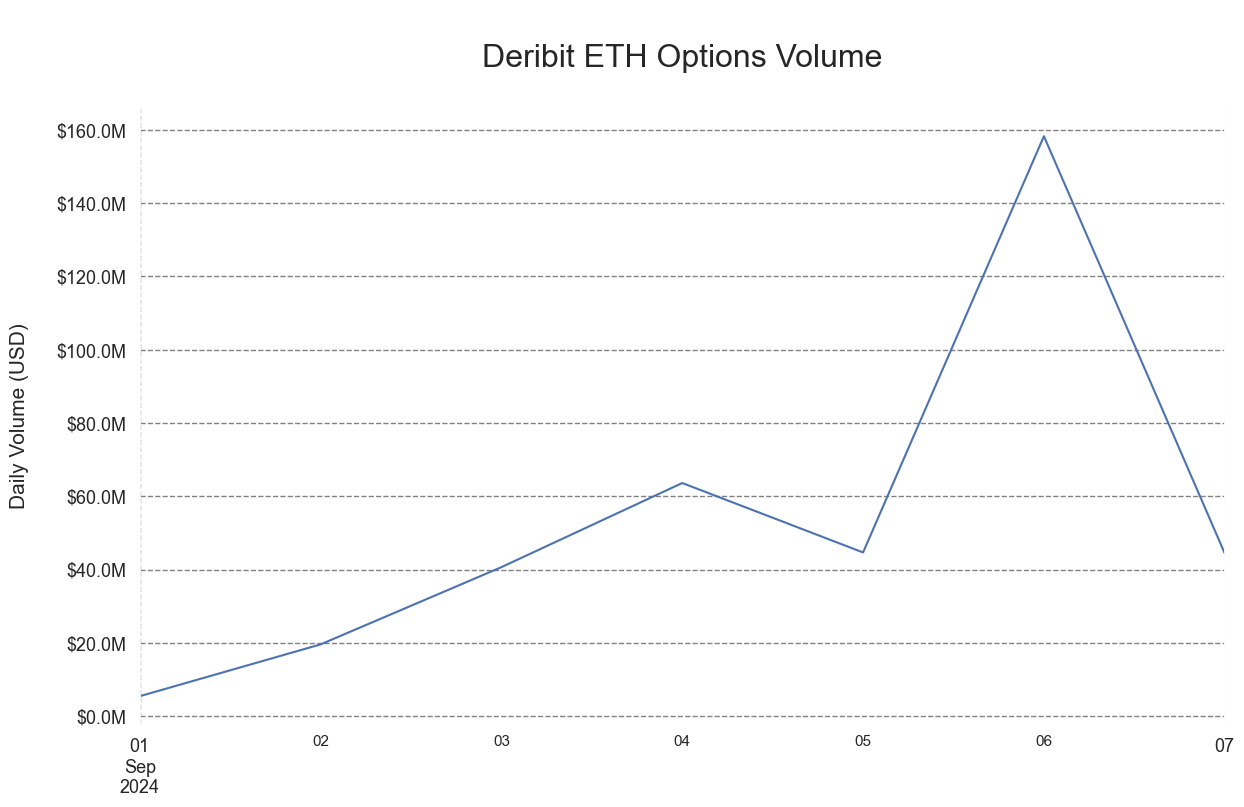

In [23]:
v = vol_sum.plot.line(y='USD Volume')
v.set_xlabel("Date", fontsize = 15)
plt.setp(v.get_yticklabels(), fontsize=13)
plt.setp(v.get_xticklabels(), fontsize=13)
v.set_xlabel("")
plt.xlim([vol_sum.index[0], vol_sum.index[-1]])
v.set_ylabel("Daily Volume (USD)\n", fontsize = 15)
v.set_title(('\nDeribit ' + str(asset).upper() + ' Options Volume\n'),fontsize=23)
v.get_legend().remove()
v.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '${:,.1f}'.format(x/1000000) + 'M'))

# OPEN INTEREST

Open interest represents the number of contracts that are currently outstanding and not settled for a specific derivatives market. 

In [24]:
# Drop markets without open interest data
oi_cat = df_asset_options.loc[df_asset_options.listing < end, 'market'].tolist()
len(oi_cat)

376

In [25]:
full_oi = pd.DataFrame()
batch_size = 420

for i in range(0, len(oi_cat),batch_size):
    mkt_batch = oi_cat[i:i+batch_size]
    print(str('\nRetrieving EOD open interest for markets ' + str(i) + ' through ' + str(i+batch_size) + '...'))
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    delta = timedelta(days=1)
    print(str(start_date) + '\n...')
    
    while start_date <= end_date:
        
        oi_batch = client.get_market_open_interest(
            markets=mkt_batch,
            start_time = start_date.strftime("%Y-%m-%d"),
            limit_per_market = 1,
            paging_from='start',
            timezone='America/New_York'
        ).to_dataframe()
        #print(oi_batch)
        full_oi = pd.concat((full_oi, oi_batch), axis = 0, ignore_index=False)
        start_date += delta
        
    print(start_date)


Retrieving EOD open interest for markets 0 through 420...
2024-09-01 00:00:00
...
2024-09-09 00:00:00


In [26]:
full_oi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2534 entries, 0 to 193
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   market          2534 non-null   string             
 1   time            2534 non-null   datetime64[ns, UTC]
 2   contract_count  2534 non-null   Int64              
 3   value_usd       2534 non-null   Float64            
 4   database_time   2534 non-null   datetime64[ns, UTC]
 5   exchange_time   2534 non-null   datetime64[ns, UTC]
dtypes: Float64(1), Int64(1), datetime64[ns, UTC](3), string(1)
memory usage: 143.5 KB


In [27]:
oi_sum = full_oi.groupby(pd.Grouper(key='time', axis=0, freq='1D', sort=True))['value_usd'].sum()

In [28]:
oi_sum.to_csv('./deribit_' + str(asset).upper() + '_options_oi_' + str(start) + '_to_' + str(end) + '.csv')
oi_sum

time
2024-09-01 00:00:00+00:00             0.0
2024-09-02 00:00:00+00:00      6467612.33
2024-09-03 00:00:00+00:00     24927750.02
2024-09-04 00:00:00+00:00     55323320.59
2024-09-05 00:00:00+00:00     59305999.71
2024-09-06 00:00:00+00:00      51922555.8
2024-09-07 00:00:00+00:00    144108764.26
2024-09-08 00:00:00+00:00    122269418.49
Freq: D, Name: value_usd, dtype: Float64

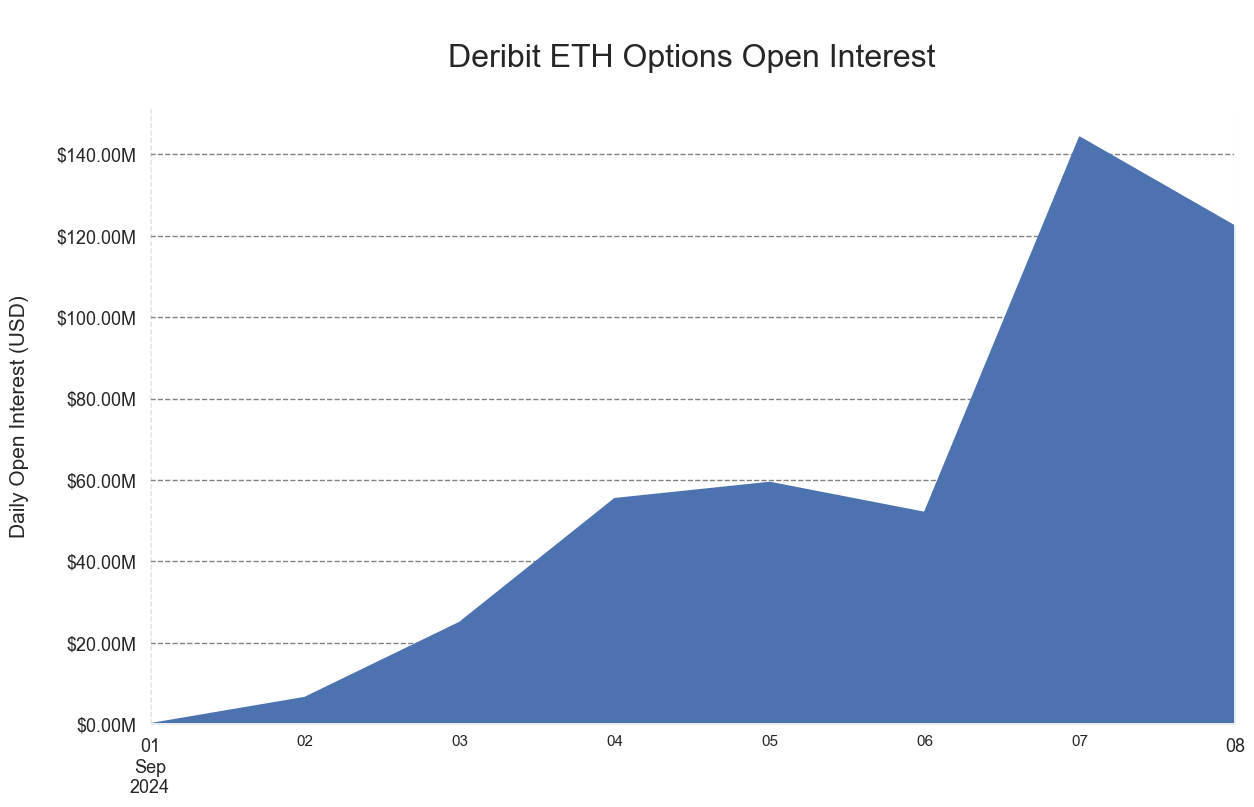

In [29]:
#p = sns.lineplot(data=vol_sum, x="time", y="USD Volume")
oi = oi_sum.plot.area(y='value_usd')
oi.set_xlabel("Date", fontsize = 15)
plt.setp(oi.get_yticklabels(), fontsize=13)
plt.setp(oi.get_xticklabels(), fontsize=13)
oi.set_xlabel("")
plt.xlim([oi_sum.index[0], oi_sum.index[-1]])
oi.set_ylabel("Daily Open Interest (USD)\n", fontsize = 15)
oi.set_title(('\nDeribit ' + str(asset).upper() + ' Options Open Interest\n'),fontsize=23)
# oi.get_legend().remove()
oi.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '${:,.2f}'.format(x/1_000_000) + 'M'))

## Split into Calls/Puts

In [30]:
full_oi_split = full_oi.merge(df_asset_options[['market','option_contract_type']],how='left', on='market')

In [31]:
full_oi_split

,market,time,contract_count,value_usd,database_time,exchange_time,option_contract_type
0,deribit-ETH-10SEP24-1950-C-option,2024-09-07 08:00:00+00:00,0,0.0,2024-09-07 08:00:19.312717+00:00,2024-09-07 08:00:00+00:00,call
1,deribit-ETH-10SEP24-1950-P-option,2024-09-07 08:00:00+00:00,0,0.0,2024-09-07 08:00:18.188738+00:00,2024-09-07 08:00:00+00:00,put
2,deribit-ETH-10SEP24-2000-C-option,2024-09-07 08:00:00+00:00,0,0.0,2024-09-07 08:00:18.188738+00:00,2024-09-07 08:00:00+00:00,call
3,deribit-ETH-10SEP24-2000-P-option,2024-09-07 08:00:00+00:00,0,0.0,2024-09-07 08:00:18.708225+00:00,2024-09-07 08:00:00+00:00,put
4,deribit-ETH-10SEP24-2050-C-option,2024-09-07 08:00:00+00:00,0,0.0,2024-09-07 08:00:18.708225+00:00,2024-09-07 08:00:00+00:00,call
...,...,...,...,...,...,...,...
2529,deribit-ETH-9SEP24-2800-P-option,2024-09-08 04:00:00+00:00,1,2285.35,2024-09-08 04:00:06.461248+00:00,2024-09-08 04:00:00+00:00,put
2530,deribit-ETH-9SEP24-2850-C-option,2024-09-08 04:00:00+00:00,0,0.0,2024-09-08 04:00:01.855497+00:00,2024-09-08 04:00:00+00:00,call
2531,deribit-ETH-9SEP24-2850-P-option,2024-09-08 04:00:00+00:00,0,0.0,2024-09-08 04:00:03.353208+00:00,2024-09-08 04:00:00+00:00,put
2532,deribit-ETH-9SEP24-2900-C-option,2024-09-08 04:00:00+00:00,0,0.0,2024-09-08 04:00:04.393566+00:00,2024-09-08 04:00:00+00:00,call


In [32]:
calls = full_oi_split.loc[(full_oi_split.option_contract_type == 'call')]
call_sum_split = calls.groupby(pd.Grouper(key='time', axis=0, freq='1D', sort=True))[['value_usd']].sum()
puts = full_oi_split.loc[(full_oi_split.option_contract_type == 'put')]
put_sum_split = puts.groupby(pd.Grouper(key='time', axis=0, freq='1D', sort=True))[['value_usd']].sum()

In [33]:
put_sum_split = put_sum_split.rename(columns={"value_usd": "Puts - USD Value", "contract_count": "Puts - Contract Count" })
call_sum_split = call_sum_split.rename(columns={"value_usd": "Calls - USD Value", "contract_count": "Calls - Contract Count" })

In [34]:
full_oi_split = call_sum_split.merge(put_sum_split,how='left', on='time')
full_oi_split

,Calls - USD Value,Puts - USD Value
time,,
2024-09-01 00:00:00+00:00,0.0,0.0
2024-09-02 00:00:00+00:00,4987937.59,1479674.74
2024-09-03 00:00:00+00:00,14177673.6,10750076.42
2024-09-04 00:00:00+00:00,30418324.31,24904996.28
2024-09-05 00:00:00+00:00,37814891.94,21491107.77
2024-09-06 00:00:00+00:00,24772293.7,27150262.1
2024-09-07 00:00:00+00:00,73624086.44,70484677.82
2024-09-08 00:00:00+00:00,61750871.09,60518547.4


In [35]:
full_oi_split['Put/Call Ratio'] = full_oi_split['Puts - USD Value'] / full_oi_split['Calls - USD Value']
full_oi_split[['Put/Call Ratio']]

,Put/Call Ratio
time,
2024-09-01 00:00:00+00:00,NaN
2024-09-02 00:00:00+00:00,0.296651
2024-09-03 00:00:00+00:00,0.75824
2024-09-04 00:00:00+00:00,0.81875
2024-09-05 00:00:00+00:00,0.568324
2024-09-06 00:00:00+00:00,1.095993
2024-09-07 00:00:00+00:00,0.957359
2024-09-08 00:00:00+00:00,0.980044


In [36]:
full_oi_split.to_csv('./deribit_' + str(asset).upper() + '_options_oi_calls_puts_' + str(start) + '_to_' + str(end) + '.csv')

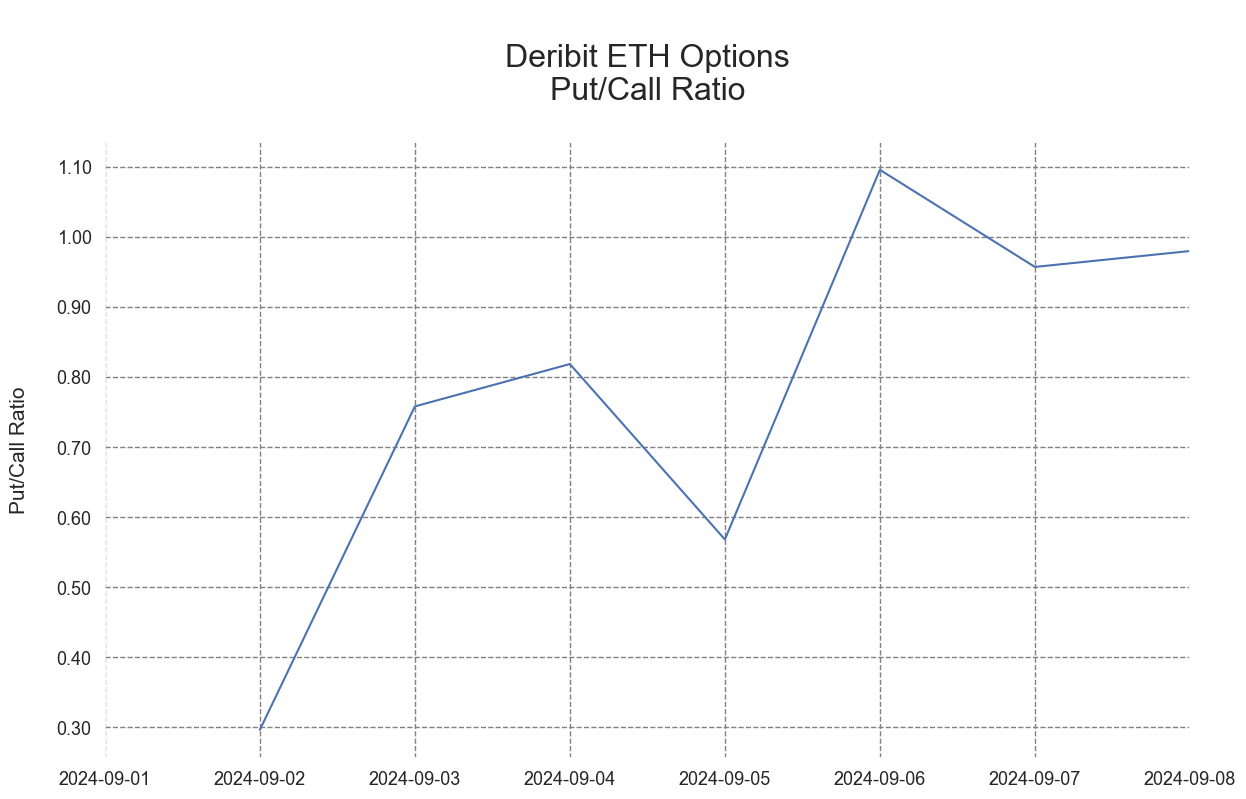

In [37]:
pc = sns.lineplot(data=full_oi_split[['Put/Call Ratio']], x="time", y="Put/Call Ratio")
pc.set_xlabel("Date", fontsize = 15)
plt.setp(pc.get_yticklabels(), fontsize=13)
plt.setp(pc.get_xticklabels(), fontsize=13)
pc.set_xlabel("")
plt.xlim([full_oi_split.index[0], full_oi_split.index[-1]])
pc.set_ylabel("Put/Call Ratio\n", fontsize = 15)
pc.set_title(('\nDeribit ' + str(asset).upper() + ' Options\nPut/Call Ratio\n'),fontsize=23)
pc.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))